# Applications of Big Data Project Notebook

Made by Adin HRELJA & Grégoire NOWACKI

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

import shap

import mlflow

import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import re

### Data Exploration

In [3]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')

In [4]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [5]:
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [6]:
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head(20)

test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
test_missing.head(20)

train_missing = train_missing.index[train_missing > 0.3]
test_missing = test_missing.index[test_missing > 0.3]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 30%% missing values' % len(all_missing))

There are 50 columns with more than 30% missing values


### Data Preprocessing

In [7]:
###READING EVERY FEATURE WITH OVER 30% MISSING VALUES

train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
train_missing = train_missing.index[train_missing > 0.3]
test_missing = test_missing.index[test_missing > 0.3]

###DROPPING EVERY FEATURE WITH OVER 30% MISSING VALUES

for i in train_missing:
    train = train.drop([i], axis = 'columns')

for i in test_missing:
    test = test.drop([i], axis = 'columns')

cat_vars = train.select_dtypes('object').columns.tolist()  

###FILLING NaN IN NUMERICAL VALUES WITH THE MEAN OF EACH COLUMN

for col in train:
    if col not in cat_vars:
        train[col] = train[col].fillna(train[col].mean())

for col in test:
    if col not in cat_vars:
        test[col] = test[col].fillna(test[col].mean())

###DROPPING REMAINING LINES WITH NaN VALUES (FROM CATEGORICAL VARIABLES)    
        
train = train.dropna(axis=0, how='any', subset=cat_vars)
test = test.dropna(axis=0, how='any', subset=cat_vars)

###LABEL ENCODING

le = LabelEncoder()

for col in train:
    if train[col].dtype == 'object':
# If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            le.fit(train[col])
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])

###ONE HOT ENCODING

train = pd.get_dummies(train)
test = pd.get_dummies(test)

#train = train.dropna(axis='columns')
#test = test.dropna(axis='columns')

labels = train['TARGET']

###ALIGN TRAIN AND TEST

train, test = train.align(test, join='inner', axis=1)
train['TARGET'] = labels

###DEFINE X AND Y

X = train.drop(columns=['TARGET'])
y = train['TARGET']

### XGBClassifier Model

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [61]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Classification report: ")
print(classification_report(y_test, y_pred))
print("Confusion matrix: ")
print(confusion_matrix(y_test, y_pred))

Accuracy: 91.81%
Classification report: 
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     92807
           1       0.47      0.03      0.05      8246

    accuracy                           0.92    101053
   macro avg       0.69      0.51      0.50    101053
weighted avg       0.88      0.92      0.88    101053

Confusion matrix: 
[[92554   253]
 [ 8023   223]]


### RandomForestClassifier Model

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

classifier = RandomForestClassifier(n_estimators=20, random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [63]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Classification report: ")
print(classification_report(y_test, y_pred))
print("Confusion matrix: ")
print(confusion_matrix(y_test, y_pred))

Accuracy: 91.83%
Classification report: 
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     92807
           1       0.42      0.00      0.01      8246

    accuracy                           0.92    101053
   macro avg       0.67      0.50      0.48    101053
weighted avg       0.88      0.92      0.88    101053

Confusion matrix: 
[[92751    56]
 [ 8205    41]]


### GradientBoostingClassifier Model

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [10]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Classification report: ")
print(classification_report(y_test, y_pred))
print("Confusion matrix: ")
print(confusion_matrix(y_test, y_pred))

Accuracy: 91.87%
Classification report: 
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     92807
           1       0.58      0.01      0.03      8246

    accuracy                           0.92    101053
   macro avg       0.75      0.51      0.49    101053
weighted avg       0.89      0.92      0.88    101053

Confusion matrix: 
[[92727    80]
 [ 8137   109]]


### XAI with SHAP Method

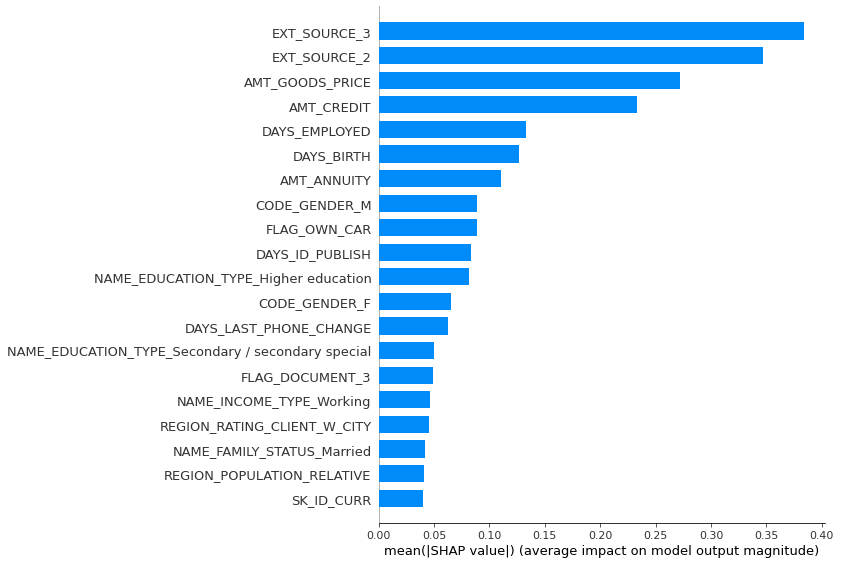

In [74]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

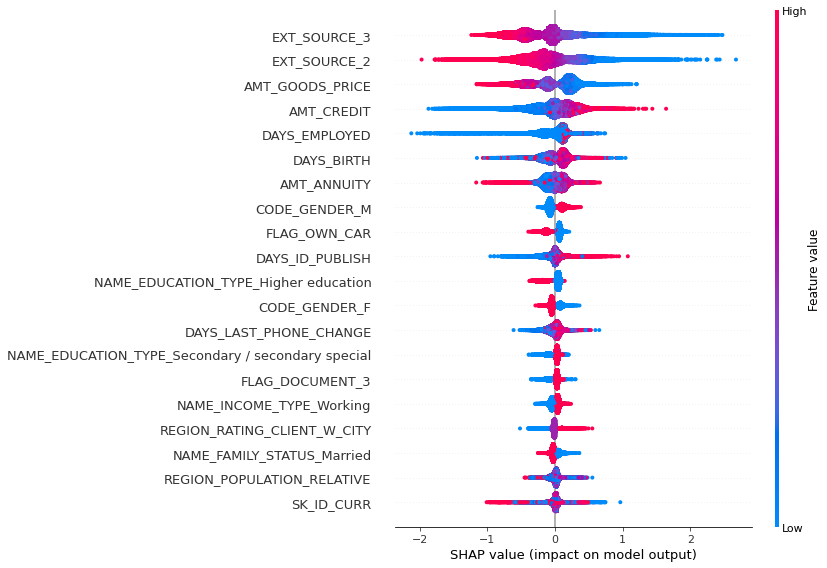

In [75]:
f = plt.figure()
shap.summary_plot(shap_values, X_test)

In [76]:
random_picks = np.arange(1,330,50)
S = X_test.iloc[random_picks]
shap.initjs()

def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [77]:
shap_plot(2)